# Risk comparison

- Comparison across risk classes (single direction)
- Comparison across risk classes (both directions at once)
- Comparison within M-risk and T-risk classes (single direction)

___

## Comparison across risk classes (single direction)

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.utils import makedir_safe
from setup_sims import bracket_prep, data_all, data_bounded, data_heavytails, data_symmetric, data_unbounded, gen_data, get_entropic, get_obfn
from setup_results import img_dir, my_fontsize, my_ext, export_legend

In [2]:
## Setup: create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prepare seed sequence; lets us align datasets across different tests.
entropy = 21281555010861417500927421083615113141
ss = np.random.SeedSequence(entropy=entropy)

In [4]:
## Setup: clerical parameters for the experiment.
n = 10000
tolerance = 1e-10
verbose = False
transparency = 0.1
flip_data = False # specify whether or not to flip the sign of the data.

In [5]:
## Data distributions to be used.
todo_data = data_all

In [6]:
## Setup of risk hyperparameters.
todo_risks = ["trisk", "cvar", "entropic", "dro"]
todo_riskparas = {
    "rrisk": ("alpha", np.linspace(1.0, 2.0, 200)),
    "trisk": ("alpha", np.linspace(1.0, 2.0, 200)),
    "cvar": ("prob", np.linspace(0.025, 0.975, 200)),
    "entropic": ("gamma", np.concatenate([np.linspace(0.01, 2.0, 200)])),
    "dro": ("atilde", np.linspace(0.025, 0.975, 200))
}
aux_riskparas = {
    "rrisk": {"sigma": 0.5, "eta": 1.0},
    "trisk": {"sigma": 0.5, "etatilde": 0.99},
    "cvar": {},
    "entropic": {},
    "dro": {}
}

In [7]:
## Setup of labels, ticks, and titles.
xlabels = {"rrisk": r"$\alpha$ value",
           "trisk": r"$\alpha$ value",
           "cvar": r"$\beta$ value",
           "entropic": r"$\gamma$ value",
           "dro": r"$(1-\widetilde{a})$ value"}
titles = {"rrisk": "M-risk",
          "trisk": "T-risk",
          "cvar": "CVaR risk",
          "entropic": "Entropic risk",
          "dro": r"$\chi^{2}$-DRO risk"}
xticks = {"rrisk": [np.amin(todo_riskparas["rrisk"][1]), np.amax(todo_riskparas["rrisk"][1])],
          "trisk": [np.amin(todo_riskparas["trisk"][1]), np.amax(todo_riskparas["trisk"][1])],
          "cvar": [0.0, 1.0],
          "entropic": [0.0, np.amax(todo_riskparas["entropic"][1])],
          "dro": [0.0, 1.0]}
xticklabels = {"rrisk": [str(tick) for tick in xticks["rrisk"]],
               "trisk": [str(tick) for tick in xticks["trisk"]],
               "cvar": [str(tick) for tick in xticks["cvar"]],
               "entropic": [str(tick) for tick in xticks["entropic"]],
               "dro": [str(tick) for tick in xticks["dro"]]}
vlines = {"rrisk": xticks["rrisk"],
          "trisk": xticks["trisk"],
          "cvar": xticks["cvar"],
          "entropic": xticks["entropic"],
          "dro": xticks["dro"]}

In [8]:
## Setup of storage dictionaries.
fun_values = { risk: {} for risk in todo_risks }
sol_values = { risk: {} for risk in todo_risks }

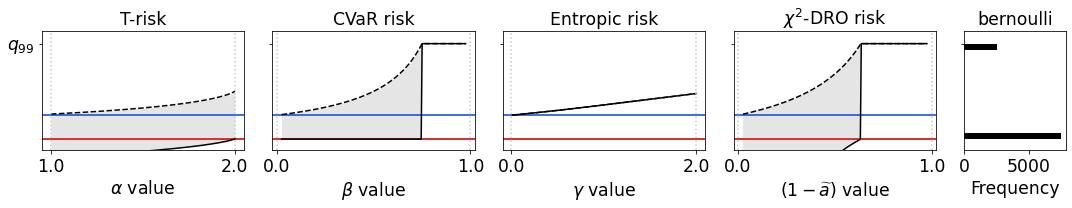

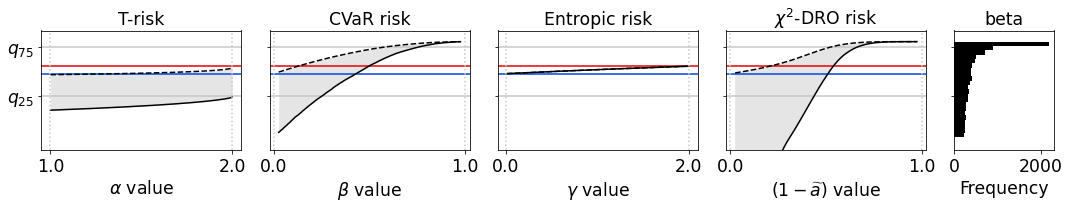

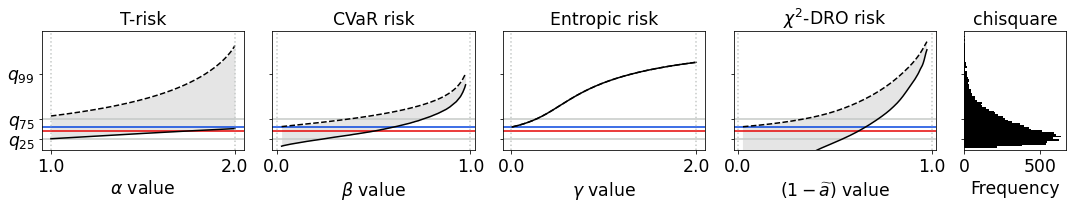

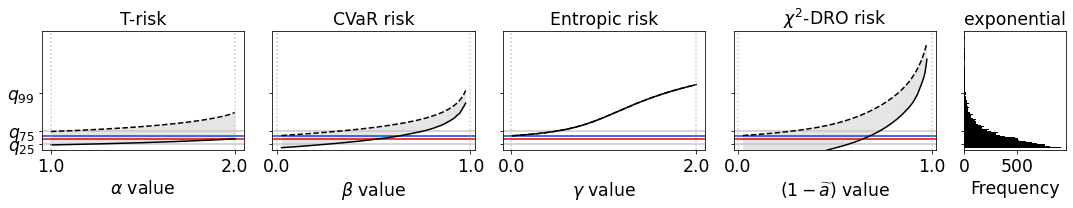

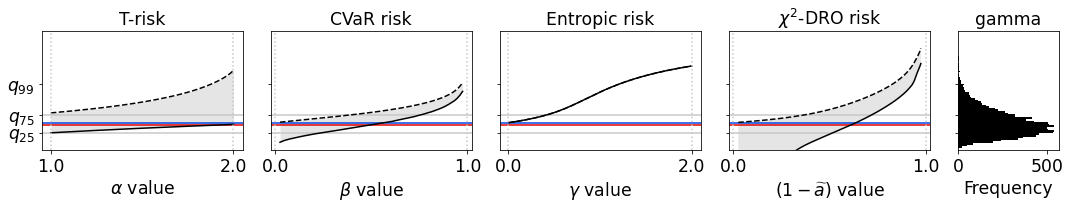

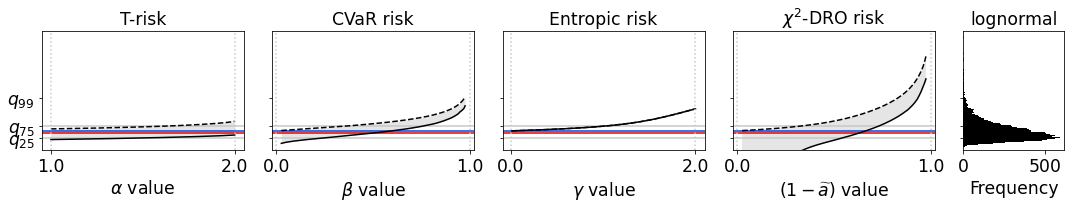

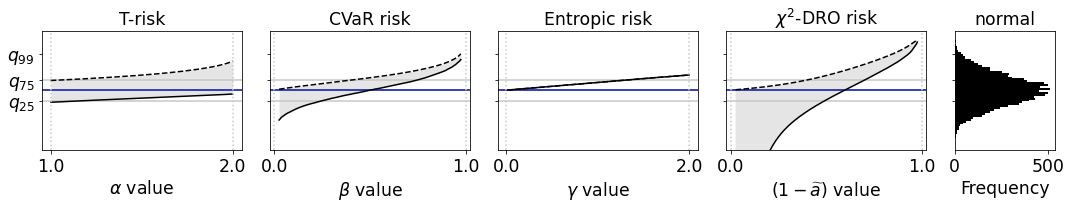

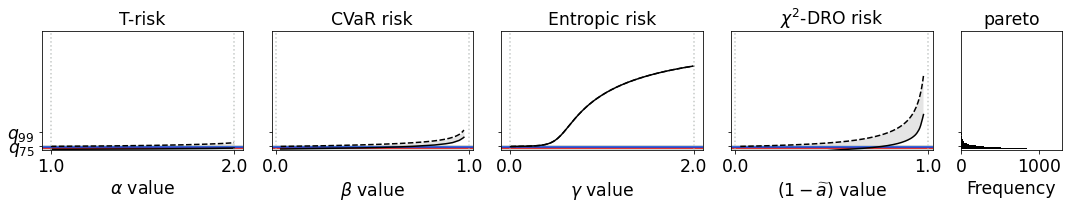

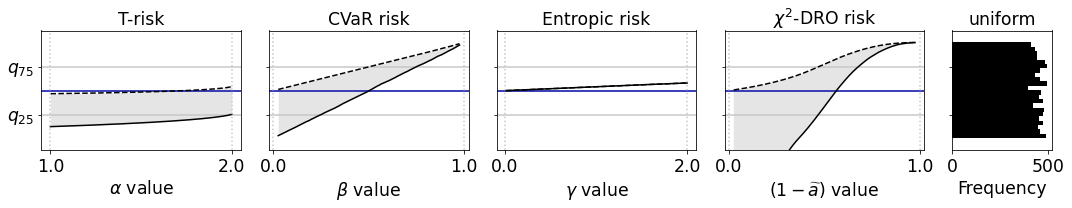

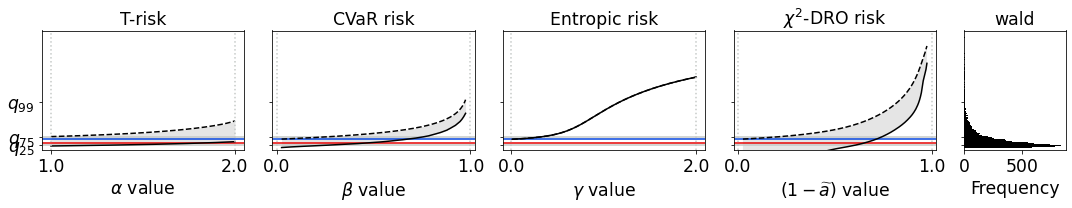

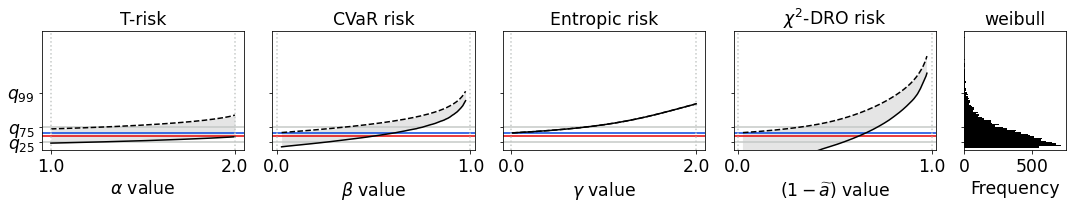

In [9]:
## Main routine.

rg = np.random.default_rng(seed=ss)

## Loop over datasets.
for data in todo_data:
    
    ## Basic statistics of the data distribution.
    x_values = gen_data(n=n, name=data, rg=rg)
    x_values = x_values - np.mean(x_values) # center the data, so we get positive and negative values.
    if flip_data:
        x_values = -x_values # flip the signs if desired.
    x_mean = np.mean(x_values)
    x_quantiles = np.quantile(a=x_values, q=[0.01, 0.25, 0.5, 0.75, 0.99])
    x_q01 = x_quantiles[0]
    x_q25 = x_quantiles[1]
    x_q50 = x_quantiles[2]
    x_q75 = x_quantiles[3]
    x_q99 = x_quantiles[4]
    x_min = np.amin(x_values)
    x_max = np.amax(x_values)
    
    if data in data_unbounded:
        if flip_data:
            yticks = [x_q01, x_q25, x_q75]
            ytick_labels = [r"$q_{01}$", r"$q_{25}$", r"$q_{75}$"]
            if data == "pareto":
                yticks = [x_q01, x_q25]
                ytick_labels = [r"$q_{01}$", r"$q_{25}$"]
        else:
            yticks = [x_q25, x_q75, x_q99]
            ytick_labels = [r"$q_{25}$", r"$q_{75}$", r"$q_{99}$"]
            if data == "pareto":
                yticks = [x_q75, x_q99]
                ytick_labels = [r"$q_{75}$", r"$q_{99}$"]
    else:
        yticks = [x_q25, x_q75]
        ytick_labels = [r"$q_{25}$", r"$q_{75}$"]
        if data == "bernoulli":
            yticks = [x_q99]
            ytick_labels = [r"$q_{99}$"]
    
    ## Loop over risk classes.
    for risk in todo_risks:
        
        pname, riskparas = todo_riskparas[risk]
        aux_paras = aux_riskparas[risk]
        
        ## Prepare storage.
        fun_values[risk][data] = []
        sol_values[risk][data] = []
        
        ## Loop over risk hyperparameters.
        for riskpara in riskparas:
            
            ## Set remaining parameter to be passed.
            aux_paras[pname] = riskpara
            
            ## Preparation of brackets for optimization.
            bracket_low, bracket_mid, bracket_high = bracket_prep(
                x=x_values, paras=aux_paras, obfn_name=risk, verbose=verbose
            )
            
            ## Prepare the objective function.
            obfn = get_obfn(name=risk)
            
            ## Run the optimization.
            opt_result = minimize_scalar(fun=obfn,
                                         bracket=(bracket_low, bracket_mid, bracket_high),
                                         bounds=(bracket_low, bracket_high),
                                         args=(x_values, aux_paras),
                                         method="bounded",
                                         options={"xatol": tolerance})
            
            ## Store the result.
            fun_values[risk][data] += [opt_result.fun]
            sol_values[risk][data] += [opt_result.x]
            
        ## After this inner loop, store in arrays.
        fun_values[risk][data] = np.copy(np.array(fun_values[risk][data]))
        sol_values[risk][data] = np.copy(np.array(sol_values[risk][data]))
    
    
    ## Put together a multi-axis figure.
    fig, axes = plt.subplots(1, 5, figsize=(15,3),
                             gridspec_kw={"width_ratios": [2,2,2,2,1]},
                             sharey=True)
    
    ## Organize the axes.
    axes_risk = axes[0:-1]
    ax_data = axes[-1]
    
    ## Plot lines or ticks that appear on all the risk plots.
    for ax in axes_risk:
        ax.axhline(y=x_q25, color="xkcd:silver")
        ax.axhline(y=x_q75, color="xkcd:silver")
        ax.axhline(y=x_q50, color="xkcd:red")
        ax.axhline(y=x_mean, color="xkcd:blue")
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.tick_params(labelsize=my_fontsize)
    
    ## Plot threshold and risk values for each class.
    for i, risk in enumerate(todo_risks):
        ax = axes[i]
        ax.plot(todo_riskparas[risk][1], fun_values[risk][data], color="xkcd:black", ls="dashed")
        ax.plot(todo_riskparas[risk][1], sol_values[risk][data], color="xkcd:black", ls="solid")
        ax.fill_between(
            x=todo_riskparas[risk][1], y1=sol_values[risk][data], y2=fun_values[risk][data],
            alpha=transparency, color="xkcd:black", lw=0
        )
        for vline in vlines[risk]:
            ax.axvline(vline, color="xkcd:silver", ls="dotted")
        ax.set_title(titles[risk], size=my_fontsize)
        ax.set_xlabel(xlabels[risk], size=my_fontsize)
        ax.set_xticks(xticks[risk])
        ax.set_xticklabels(xticklabels[risk])
    
    ## Plot the data histogram.
    ax_data.hist(x_values,
                 bins="auto", color="black", hatch=None,
                 orientation="horizontal", density=False)
    ax_data.tick_params(labelsize=my_fontsize)
    ax_data.set_xlabel("Frequency", size=my_fontsize)
    ax_data.set_title(data, size=my_fontsize)
    
    ## Put a bit of effort into ensuring the visuals are clear.
    if data in data_bounded:
        ylim_top = x_max + 0.1 + 0.05*np.absolute(x_max)
        ylim_bottom = x_min - 0.1 - 0.05*np.absolute(x_min)
    else:
        ylim_top = x_max + 0.1 + 0.05*np.absolute(x_max)
        ylim_bottom = x_min - 0.1 - 0.05*np.absolute(x_min)
        if data in data_symmetric:
            diff_top = ylim_top - x_mean
            diff_bottom = x_mean - ylim_bottom
            if diff_top >= diff_bottom:
                ylim_bottom = x_mean - diff_top
            else:
                ylim_top = x_mean + diff_bottom
    for ax in axes:
        ax.set_ylim(top=ylim_top, bottom=ylim_bottom)
    
    ## Output the figure.
    if flip_data:
        fname = path.join(img_dir, "risk_breakdown_overshape_{}_flipped.{}".format(data, my_ext))
    else:
        fname = path.join(img_dir, "risk_breakdown_overshape_{}.{}".format(data, my_ext))
    plt.tight_layout()
    plt.savefig(fname=fname)
    plt.show()

___

## Comparison across risk classes (both directions at once)

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.utils import makedir_safe
from setup_sims import bracket_prep, data_all, data_bounded, data_heavytails, data_symmetric, data_unbounded, gen_data, get_entropic, get_obfn
from setup_results import img_dir, my_fontsize, my_ext, export_legend

In [2]:
## Setup: create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prepare seed sequence; lets us align datasets across different tests.
entropy = 21281555010861417500927421083615113141
ss = np.random.SeedSequence(entropy=entropy)

In [4]:
## Setup: clerical parameters for the experiment.
n = 10000
tolerance = 1e-10
verbose = False
transparency = 0.1

In [5]:
## Data distributions to be used.
todo_data = data_all

In [6]:
## Setup of risk hyperparameters.
todo_risks = ["trisk", "cvar", "entropic", "dro"]
todo_riskparas = {
    "rrisk": ("alpha", np.linspace(1.0, 2.0, 200)),
    "trisk": ("alpha", np.linspace(1.0, 2.0, 200)),
    "cvar": ("prob", np.linspace(0.025, 0.975, 200)),
    "entropic": ("gamma", np.concatenate([np.linspace(0.01, 2.0, 200)])),
    "dro": ("atilde", np.linspace(0.025, 0.975, 200))
}
aux_riskparas = {
    "rrisk": {"sigma": 0.5, "eta": 1.0},
    "trisk": {"sigma": 0.5, "etatilde": 0.99},
    "cvar": {},
    "entropic": {},
    "dro": {}
}

In [7]:
## Setup of labels, ticks, and titles.
xlabels = {"rrisk": r"$\alpha$ value",
           "trisk": r"$\alpha$ value",
           "cvar": r"$\beta$ value",
           "entropic": r"$\gamma$ value",
           "dro": r"$(1-\widetilde{a})$ value"}
titles = {"rrisk": "M-risk",
          "trisk": "T-risk",
          "cvar": "CVaR risk",
          "entropic": "Entropic risk",
          "dro": r"$\chi^{2}$-DRO risk"}
xticks = {"rrisk": [np.amin(todo_riskparas["rrisk"][1]), np.amax(todo_riskparas["rrisk"][1])],
          "trisk": [np.amin(todo_riskparas["trisk"][1]), np.amax(todo_riskparas["trisk"][1])],
          "cvar": [0.0, 1.0],
          "entropic": [0.0, np.amax(todo_riskparas["entropic"][1])],
          "dro": [0.0, 1.0]}
xticklabels = {"rrisk": [str(tick) for tick in xticks["rrisk"]],
               "trisk": [str(tick) for tick in xticks["trisk"]],
               "cvar": [str(tick) for tick in xticks["cvar"]],
               "entropic": [str(tick) for tick in xticks["entropic"]],
               "dro": [str(tick) for tick in xticks["dro"]]}
vlines = {"rrisk": xticks["rrisk"],
          "trisk": xticks["trisk"],
          "cvar": xticks["cvar"],
          "entropic": xticks["entropic"],
          "dro": xticks["dro"]}

In [8]:
## Setup of storage dictionaries.
fun_values = { risk: {} for risk in todo_risks }
sol_values = { risk: {} for risk in todo_risks }
fun_values_flipped = { risk: {} for risk in todo_risks }
sol_values_flipped = { risk: {} for risk in todo_risks }

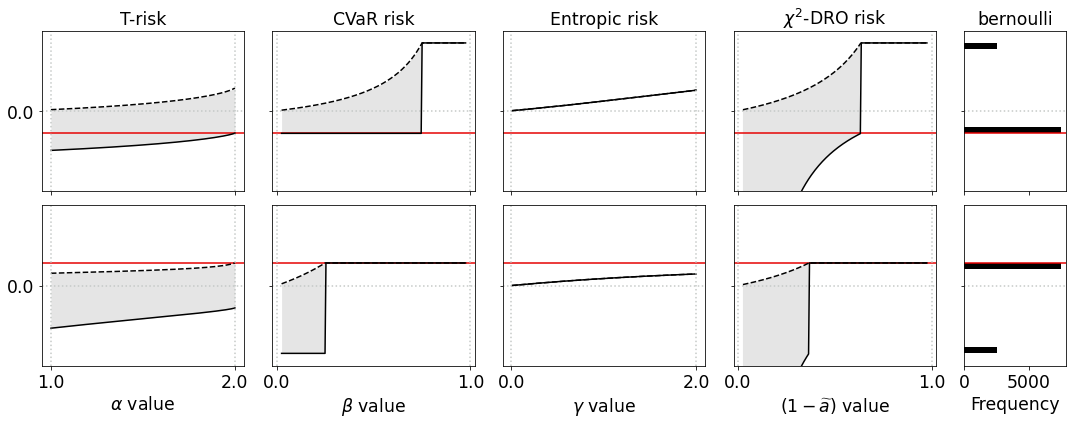

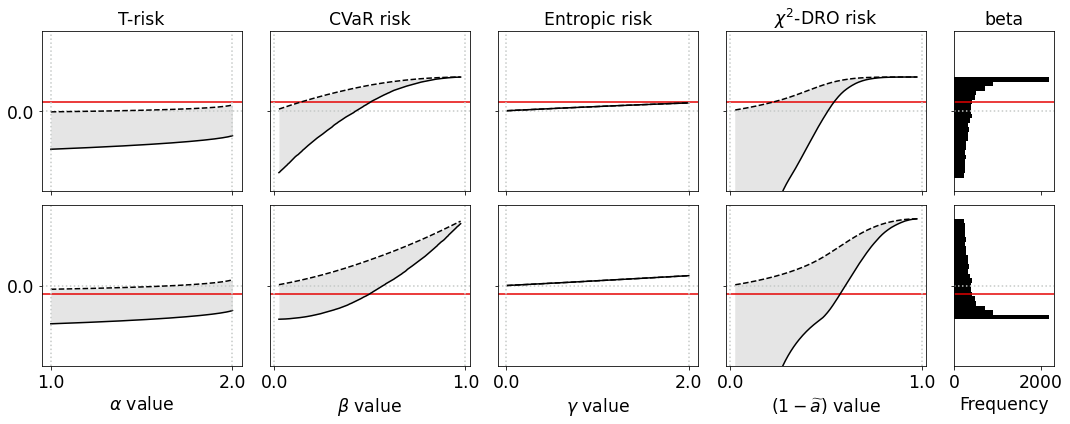

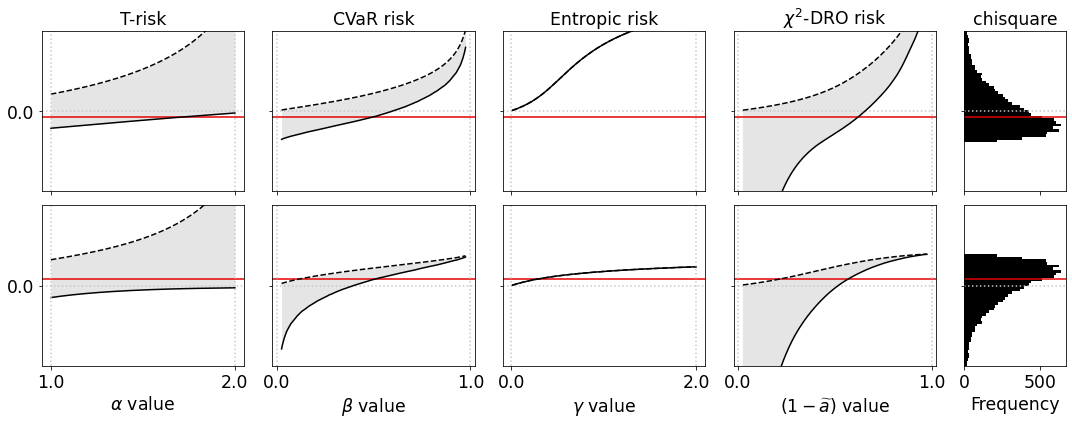

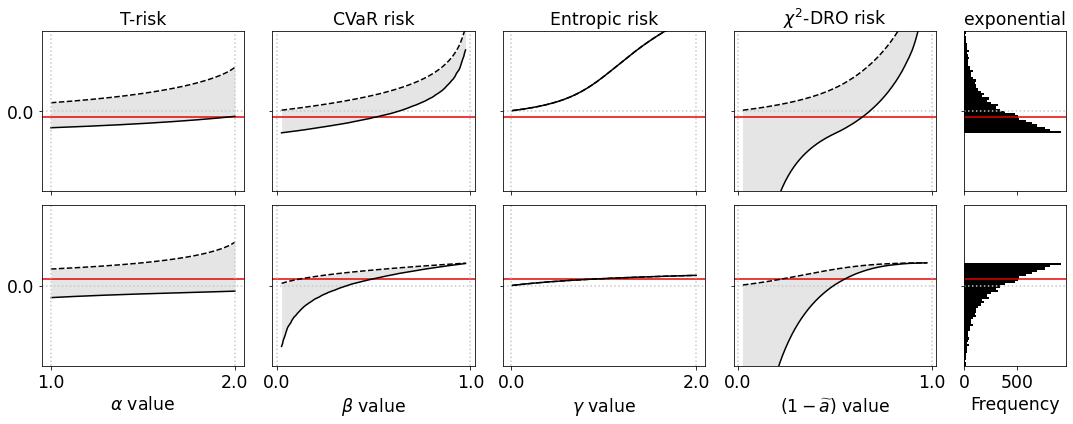

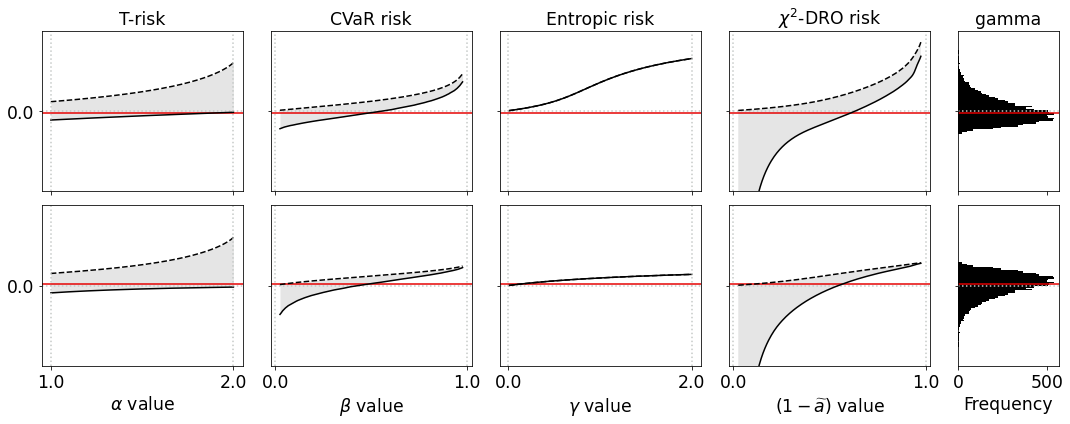

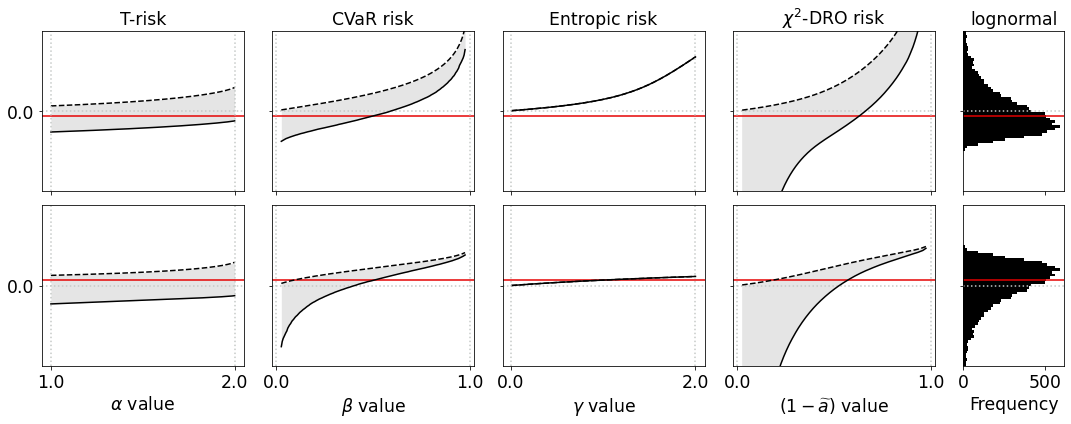

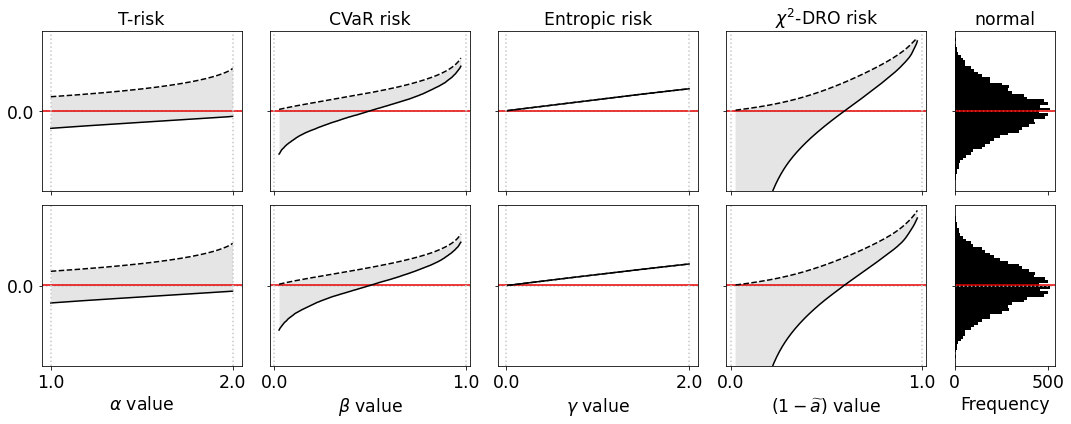

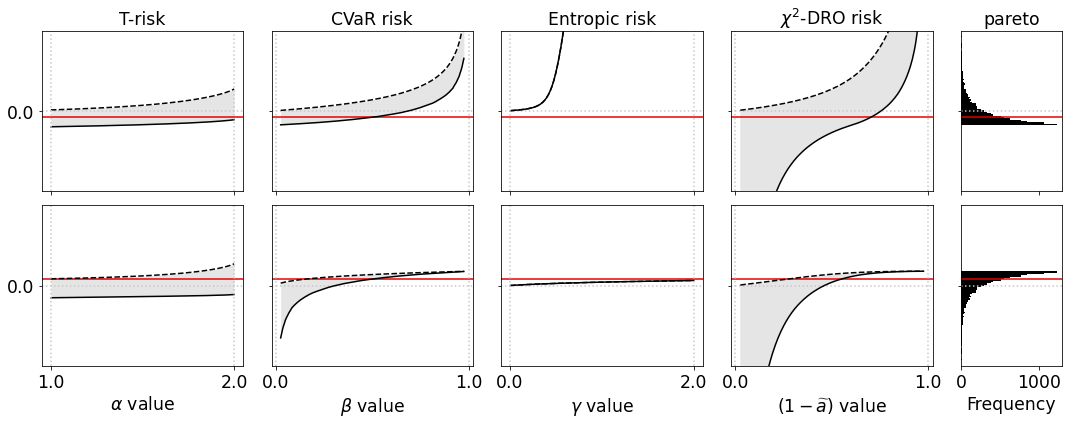

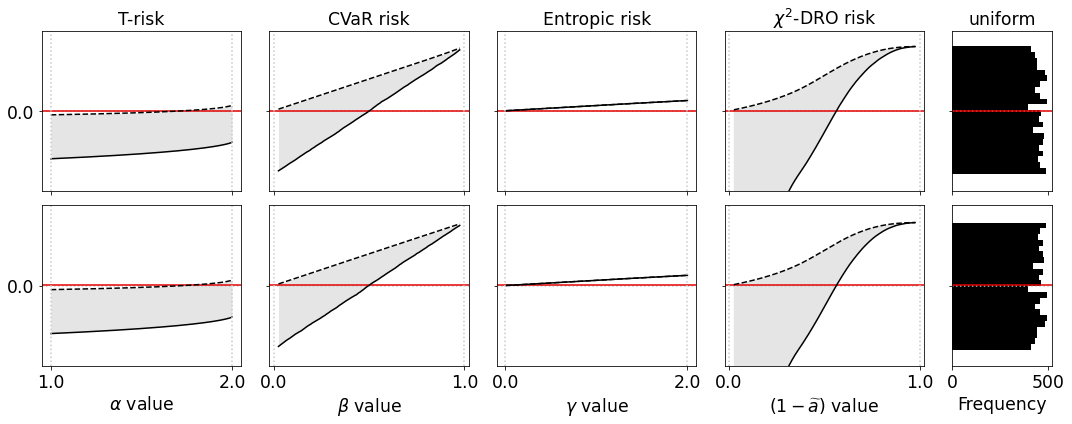

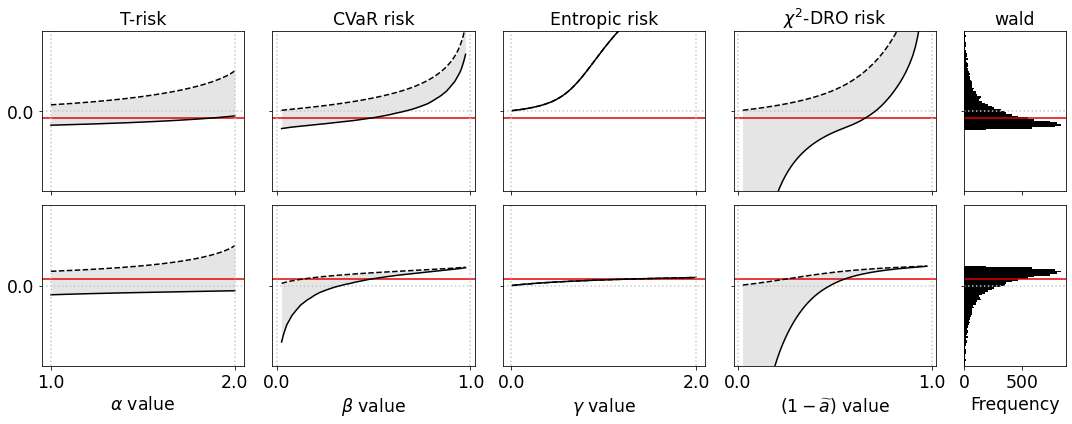

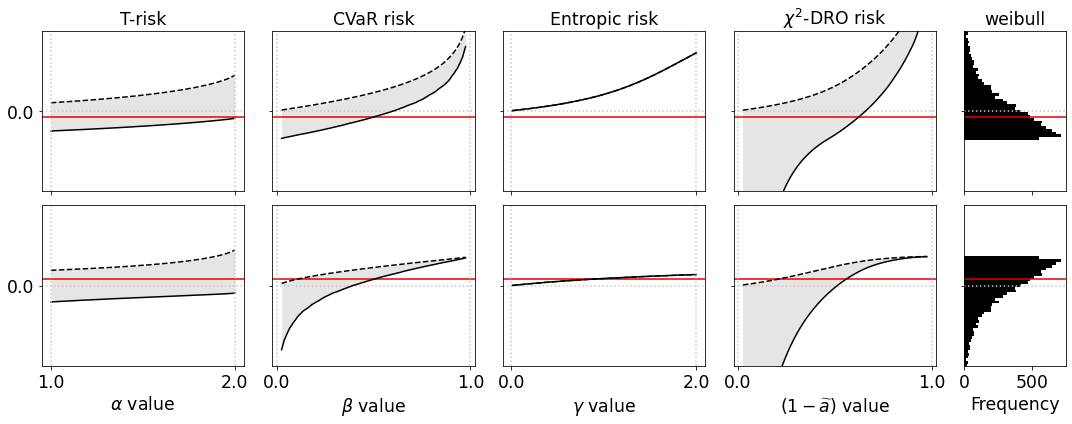

In [9]:
## Main routine.

rg = np.random.default_rng(seed=ss)

## Loop over datasets.
for data in todo_data:
    
    ## Basic statistics of the data distribution.
    x_values = gen_data(n=n, name=data, rg=rg)
    x_values = x_values - np.mean(x_values) # center the data, so we get positive and negative values.
    x_values_flipped = -x_values
    x_mean = np.mean(x_values)
    x_quantiles = np.quantile(a=x_values, q=[0.01, 0.25, 0.5, 0.75, 0.99])
    x_quantiles_flipped = np.quantile(a=x_values_flipped, q=[0.01, 0.25, 0.5, 0.75, 0.99])
    x_median = x_quantiles[2]
    x_median_flipped = x_quantiles_flipped[2]
    
    ## Ticks on the vertical axis are kept as simple as possible.
    yticks = [0.0]
    ytick_labels = [str(0.0)]
    
    ## Put a bit of effort into ensuring the visuals are clear.
    if data in data_bounded:
        ## If bounded, show all the data.
        ylim_top = np.amax(np.absolute(x_values))*(1.05) + 0.1
        ylim_bottom = -ylim_top
    else:
        ## Otherwise, use max values as a guide.
        ylim_top = np.amax(np.absolute(x_values))
        ylim_bottom = -ylim_top
        if data in data_heavytails:
            ylim_top = x_quantiles[-1]
            ylim_bottom = -x_quantiles[-1]
    
    ## First loop over risk classes (with original, pre-flip data).
    for risk in todo_risks:
        
        pname, riskparas = todo_riskparas[risk]
        aux_paras = aux_riskparas[risk]
        
        ## Prepare storage.
        fun_values[risk][data] = []
        sol_values[risk][data] = []
        
        ## Loop over risk hyperparameters.
        for riskpara in riskparas:
            
            ## Set remaining parameter to be passed.
            aux_paras[pname] = riskpara
            
            ## Preparation of brackets for optimization.
            bracket_low, bracket_mid, bracket_high = bracket_prep(
                x=x_values, paras=aux_paras, obfn_name=risk, verbose=verbose
            )
            
            ## Prepare the objective function.
            obfn = get_obfn(name=risk)
            
            ## Run the optimization.
            opt_result = minimize_scalar(fun=obfn,
                                         bracket=(bracket_low, bracket_mid, bracket_high),
                                         bounds=(bracket_low, bracket_high),
                                         args=(x_values, aux_paras),
                                         method="bounded",
                                         options={"xatol": tolerance})
            
            ## Store the result.
            fun_values[risk][data] += [opt_result.fun]
            sol_values[risk][data] += [opt_result.x]
            
        ## After this inner loop, store in arrays.
        fun_values[risk][data] = np.copy(np.array(fun_values[risk][data]))
        sol_values[risk][data] = np.copy(np.array(sol_values[risk][data]))
    
    
    ## Second loop over risk classes (now using flipped data).
    for risk in todo_risks:
        
        pname, riskparas = todo_riskparas[risk]
        aux_paras = aux_riskparas[risk]
        
        ## Prepare storage.
        fun_values_flipped[risk][data] = []
        sol_values_flipped[risk][data] = []
        
        ## Loop over risk hyperparameters.
        for riskpara in riskparas:
            
            ## Set remaining parameter to be passed.
            aux_paras[pname] = riskpara
            
            ## Preparation of brackets for optimization.
            bracket_low, bracket_mid, bracket_high = bracket_prep(
                x=x_values_flipped, paras=aux_paras, obfn_name=risk, verbose=verbose
            )
            
            ## Prepare the objective function.
            obfn = get_obfn(name=risk)
            
            ## Run the optimization.
            opt_result = minimize_scalar(fun=obfn,
                                         bracket=(bracket_low, bracket_mid, bracket_high),
                                         bounds=(bracket_low, bracket_high),
                                         args=(x_values_flipped, aux_paras),
                                         method="bounded",
                                         options={"xatol": tolerance})
            
            ## Store the result.
            fun_values_flipped[risk][data] += [opt_result.fun]
            sol_values_flipped[risk][data] += [opt_result.x]
            
        ## After this inner loop, store in arrays.
        fun_values_flipped[risk][data] = np.copy(np.array(fun_values_flipped[risk][data]))
        sol_values_flipped[risk][data] = np.copy(np.array(sol_values_flipped[risk][data]))
    
    
    ## Put together a multi-axis figure.
    fig, axes = plt.subplots(2, 5, figsize=(15,6),
                             gridspec_kw={"width_ratios": [2,2,2,2,1]},
                             sharey="row", sharex="col")
    
    ## Organize the axes.
    axes_risk_top = axes[0,:-1]
    axes_risk_bottom = axes[1,:-1]
    ax_data_top = axes[0,-1]
    ax_data_bottom = axes[1,-1]
    
    ## Plot lines or ticks that appear on all the risk plots.
    for j in range(axes.shape[1]):
        ax_top = axes[0,j]
        ax_bottom = axes[1,j]
        ax_top.axhline(y=0.0, color="xkcd:silver", ls="dotted")
        ax_top.axhline(y=x_median, color="xkcd:red")
        ax_top.set_yticks(yticks)
        ax_top.set_yticklabels(ytick_labels)
        ax_top.tick_params(labelsize=my_fontsize)
        ax_bottom.axhline(y=0.0, color="xkcd:silver", ls="dotted")
        ax_bottom.axhline(y=x_median_flipped, color="xkcd:red")
        ax_bottom.set_yticks(yticks)
        ax_bottom.set_yticklabels(ytick_labels)
        ax_bottom.tick_params(labelsize=my_fontsize)
    
    ## Plot threshold and risk values for each class.
    for j, risk in enumerate(todo_risks):
        ax_top = axes[0,j]
        ax_bottom = axes[1,j]
        ax_top.plot(todo_riskparas[risk][1], fun_values[risk][data], color="xkcd:black", ls="dashed")
        ax_top.plot(todo_riskparas[risk][1], sol_values[risk][data], color="xkcd:black", ls="solid")
        ax_top.fill_between(
            x=todo_riskparas[risk][1], y1=sol_values[risk][data], y2=fun_values[risk][data],
            alpha=transparency, color="xkcd:black", lw=0
        )
        ax_bottom.plot(todo_riskparas[risk][1], fun_values_flipped[risk][data], color="xkcd:black", ls="dashed")
        ax_bottom.plot(todo_riskparas[risk][1], sol_values_flipped[risk][data], color="xkcd:black", ls="solid")
        ax_bottom.fill_between(
            x=todo_riskparas[risk][1], y1=sol_values_flipped[risk][data], y2=fun_values_flipped[risk][data],
            alpha=transparency, color="xkcd:black", lw=0
        )
        for vline in vlines[risk]:
            ax_top.axvline(vline, color="xkcd:silver", ls="dotted")
            ax_bottom.axvline(vline, color="xkcd:silver", ls="dotted")
        ax_top.set_title(titles[risk], size=my_fontsize)
        ax_bottom.set_xlabel(xlabels[risk], size=my_fontsize)
        ax_top.set_xticks(xticks[risk])
        ax_bottom.set_xticks(xticks[risk])
        ax_bottom.set_xticklabels(xticklabels[risk])
        ax_top.set_ylim(top=ylim_top, bottom=ylim_bottom)
        ax_bottom.set_ylim(top=ylim_top, bottom=ylim_bottom)
    
    ## Plot the data histogram.
    ax_data_top.hist(x_values,
                     bins="auto", color="black", hatch=None,
                     orientation="horizontal", density=False)
    ax_data_top.tick_params(labelsize=my_fontsize)
    ax_data_bottom.hist(x_values_flipped,
                     bins="auto", color="black", hatch=None,
                     orientation="horizontal", density=False)
    ax_data_bottom.tick_params(labelsize=my_fontsize)
    ax_data_bottom.set_xlabel("Frequency", size=my_fontsize)
    ax_data_top.set_title(data, size=my_fontsize)
    ax_data_top.set_ylim(top=ylim_top, bottom=ylim_bottom)
    ax_data_bottom.set_ylim(top=ylim_top, bottom=ylim_bottom)
    
    ## Output the figure.
    fname = path.join(img_dir, "fliptest_overshape_{}.{}".format(data, my_ext))
    plt.tight_layout()
    plt.savefig(fname=fname)
    plt.show()

___

## Comparison within M-risk and T-risk classes (single direction)

In [1]:
## External modules.
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.utils import makedir_safe
from setup_sims import bracket_prep, data_all, data_bounded, data_heavytails, data_symmetric, data_unbounded, gen_data, get_entropic, get_obfn
from setup_results import img_dir, my_fontsize, my_ext, export_legend

In [2]:
## Setup: create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prepare seed sequence; lets us align datasets across different tests.
entropy = 21281555010861417500927421083615113141
ss = np.random.SeedSequence(entropy=entropy)

In [4]:
## Setup: clerical parameters for the experiment.
n = 10000
tolerance = 1e-10
verbose = False
transparency = 0.1
flip_data = False # specify whether or not to flip the sign of the data.

In [5]:
## Data distributions to be used.
todo_data = data_all

In [6]:
## Setup of risk hyperparameters.
todo_risks = ["rrisk", "rrisk_sigma", "trisk_sigma", "trisk_etatilde"]
todo_riskparas = {
    "rrisk": ("alpha", np.linspace(1.0, 2.0, 200)),
    "rrisk_sigma": ("sigma", np.linspace(0.05, 1.5, 200)),
    "trisk_sigma": ("sigma", np.linspace(0.05, 1.5, 200)),
    "trisk_etatilde": ("etatilde", np.linspace(-1.0, 1.0, 200))
}
aux_riskparas = {
    "rrisk": {"sigma": 0.5, "eta": 1.0},
    "rrisk_sigma": {"alpha": 1.0, "eta": 1.0},
    "trisk_sigma": {"alpha": 1.0, "etatilde": (1.0/1.5)-0.01},
    "trisk_etatilde": {"sigma": 0.99, "alpha": 1.0}
}

In [7]:
## Setup of labels, ticks, and titles.
xlabels = {"rrisk": r"$\alpha$ value",
           "rrisk_sigma": r"$\sigma$ value",
           "trisk_sigma": r"$\sigma$ value",
           "trisk_etatilde": r"$\widetilde{\eta}$ value"}
titles = {"rrisk": "M-risk",
          "rrisk_sigma": "M-risk",
          "trisk_sigma": "T-risk",
          "trisk_etatilde": "T-risk"}
xticks = {"rrisk": [np.amin(todo_riskparas["rrisk"][1]),
                    np.amax(todo_riskparas["rrisk"][1])],
          "rrisk_sigma": [np.amin(todo_riskparas["rrisk_sigma"][1]),
                          np.amax(todo_riskparas["rrisk_sigma"][1])],
          "trisk_sigma": [np.amin(todo_riskparas["trisk_sigma"][1]),
                          np.amax(todo_riskparas["trisk_sigma"][1])],
          "trisk_etatilde": [np.amin(todo_riskparas["trisk_etatilde"][1]),
                             np.amax(todo_riskparas["trisk_etatilde"][1])]}
xticklabels = {"rrisk": [str(tick) for tick in xticks["rrisk"]],
               "rrisk_sigma": [str(tick) for tick in xticks["rrisk_sigma"]],
               "trisk_sigma": [str(tick) for tick in xticks["trisk_sigma"]],
               "trisk_etatilde": [str(tick) for tick in xticks["trisk_etatilde"]]}
vlines = {"rrisk": xticks["rrisk"],
          "rrisk_sigma": xticks["rrisk_sigma"],
          "trisk_sigma": xticks["trisk_sigma"],
          "trisk_etatilde": xticks["trisk_etatilde"]}

In [8]:
## Setup of storage dictionaries.
fun_values = { risk: {} for risk in todo_risks }
sol_values = { risk: {} for risk in todo_risks }

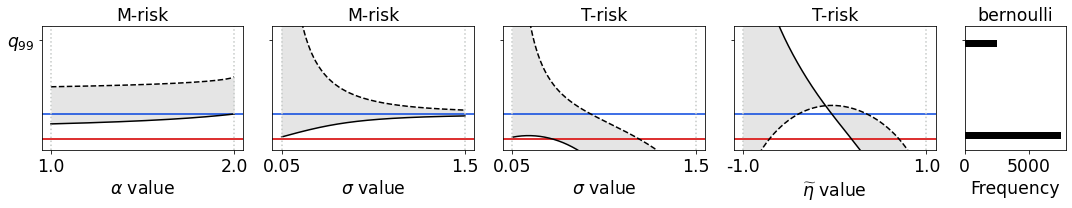

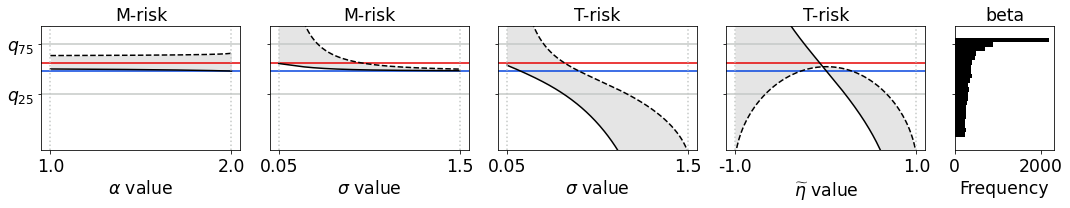

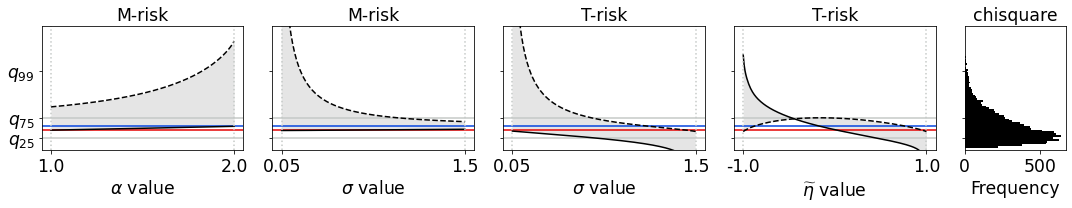

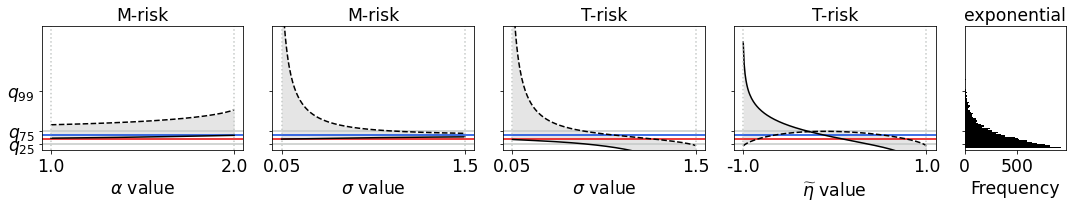

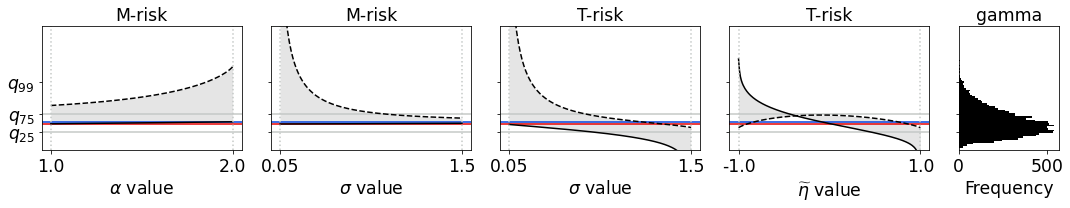

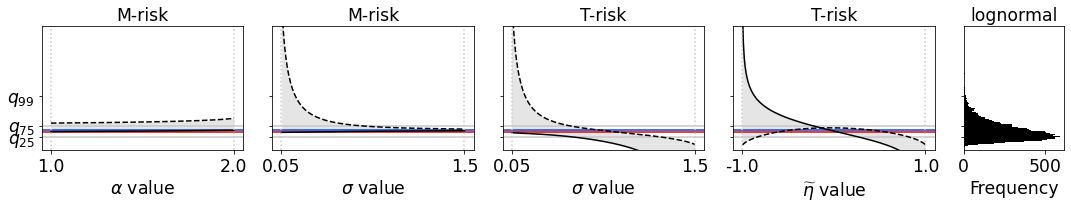

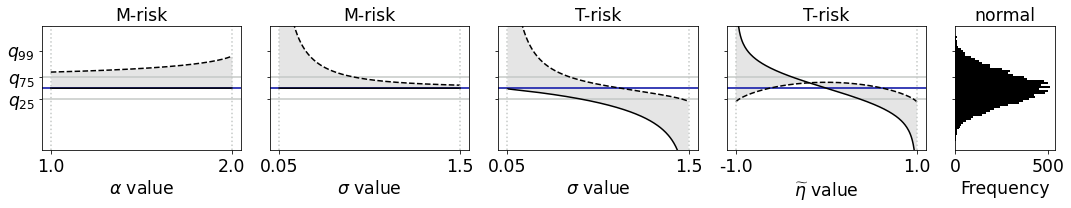

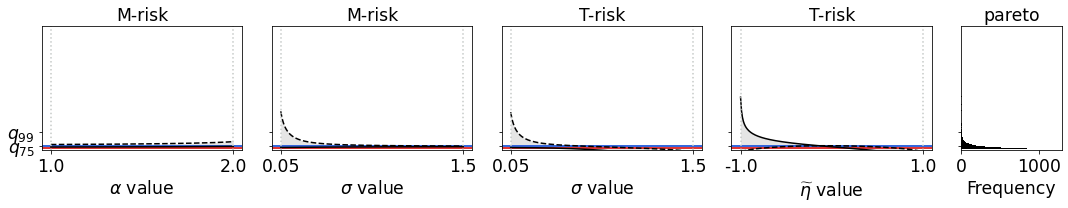

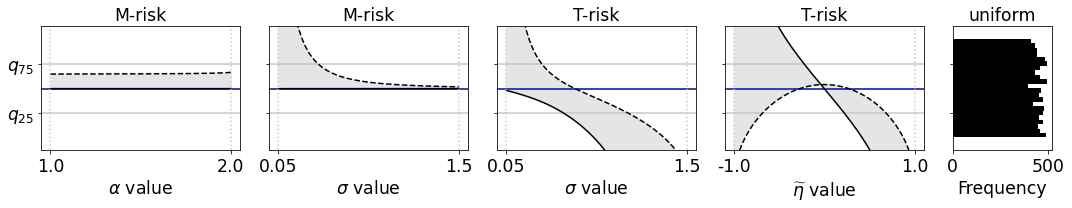

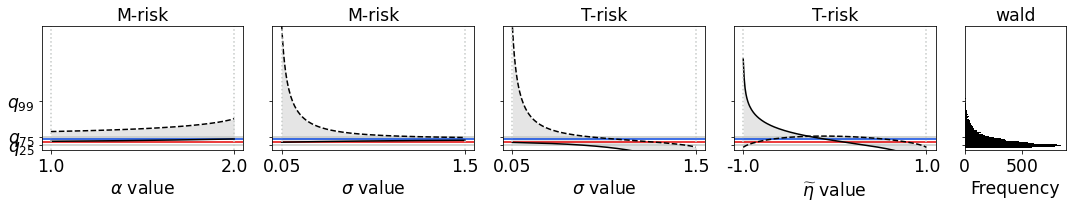

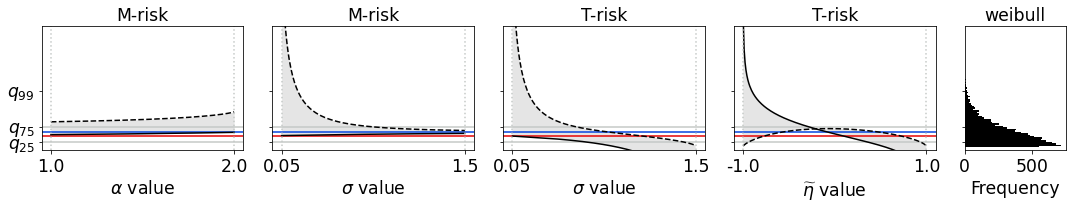

In [9]:
## Main routine.

rg = np.random.default_rng(seed=ss)

## Loop over datasets.
for data in todo_data:
    
    ## Basic statistics of the data distribution.
    x_values = gen_data(n=n, name=data, rg=rg)
    x_values = x_values - np.mean(x_values) # center the data, so we get positive and negative values.
    if flip_data:
        x_values = -x_values # flip the signs if desired.
    x_mean = np.mean(x_values)
    x_quantiles = np.quantile(a=x_values, q=[0.01, 0.25, 0.5, 0.75, 0.99])
    x_q01 = x_quantiles[0]
    x_q25 = x_quantiles[1]
    x_q50 = x_quantiles[2]
    x_q75 = x_quantiles[3]
    x_q99 = x_quantiles[4]
    x_min = np.amin(x_values)
    x_max = np.amax(x_values)
    
    if data in data_unbounded:
        if flip_data:
            yticks = [x_q01, x_q25, x_q75]
            ytick_labels = [r"$q_{01}$", r"$q_{25}$", r"$q_{75}$"]
            if data == "pareto":
                yticks = [x_q01, x_q25]
                ytick_labels = [r"$q_{01}$", r"$q_{25}$"]
        else:
            yticks = [x_q25, x_q75, x_q99]
            ytick_labels = [r"$q_{25}$", r"$q_{75}$", r"$q_{99}$"]
            if data == "pareto":
                yticks = [x_q75, x_q99]
                ytick_labels = [r"$q_{75}$", r"$q_{99}$"]
    else:
        yticks = [x_q25, x_q75]
        ytick_labels = [r"$q_{25}$", r"$q_{75}$"]
        if data == "bernoulli":
            yticks = [x_q99]
            ytick_labels = [r"$q_{99}$"]
    
    ## Loop over risk classes.
    for risk in todo_risks:
        
        pname, riskparas = todo_riskparas[risk]
        aux_paras = aux_riskparas[risk]
        
        ## Prepare storage.
        fun_values[risk][data] = []
        sol_values[risk][data] = []
        
        ## Loop over risk hyperparameters.
        for riskpara in riskparas:
            
            ## Set remaining parameter to be passed.
            aux_paras[pname] = riskpara
            
            ## Preparation of brackets for optimization.
            obfn_name = risk.split("_")[0] # special parsing here.
            bracket_low, bracket_mid, bracket_high = bracket_prep(
                x=x_values, paras=aux_paras, obfn_name=obfn_name, verbose=verbose
            )
            
            ## Prepare the objective function.
            obfn = get_obfn(name=obfn_name)
            
            ## Run the optimization.
            opt_result = minimize_scalar(fun=obfn,
                                         bracket=(bracket_low, bracket_mid, bracket_high),
                                         bounds=(bracket_low, bracket_high),
                                         args=(x_values, aux_paras),
                                         method="bounded",
                                         options={"xatol": tolerance})
            
            ## Store the result.
            fun_values[risk][data] += [opt_result.fun]
            sol_values[risk][data] += [opt_result.x]
            
        ## After this inner loop, store in arrays.
        fun_values[risk][data] = np.copy(np.array(fun_values[risk][data]))
        sol_values[risk][data] = np.copy(np.array(sol_values[risk][data]))
    
    
    ## Put together a multi-axis figure.
    fig, axes = plt.subplots(1, 5, figsize=(15,3),
                             gridspec_kw={"width_ratios": [2,2,2,2,1]},
                             sharey=True)
    
    ## Organize the axes.
    axes_risk = axes[0:-1]
    ax_data = axes[-1]
    
    ## Plot lines or ticks that appear on all the risk plots.
    for ax in axes_risk:
        ax.axhline(y=x_q25, color="xkcd:silver")
        ax.axhline(y=x_q75, color="xkcd:silver")
        ax.axhline(y=x_q50, color="xkcd:red")
        ax.axhline(y=x_mean, color="xkcd:blue")
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.tick_params(labelsize=my_fontsize)
    
    ## Plot threshold and risk values for each class.
    for i, risk in enumerate(todo_risks):
        ax = axes[i]
        ax.plot(todo_riskparas[risk][1], fun_values[risk][data], color="xkcd:black", ls="dashed")
        ax.plot(todo_riskparas[risk][1], sol_values[risk][data], color="xkcd:black", ls="solid")
        ax.fill_between(
            x=todo_riskparas[risk][1], y1=sol_values[risk][data], y2=fun_values[risk][data],
            alpha=transparency, color="xkcd:black", lw=0
        )
        for vline in vlines[risk]:
            ax.axvline(vline, color="xkcd:silver", ls="dotted")
        ax.set_title(titles[risk], size=my_fontsize)
        ax.set_xlabel(xlabels[risk], size=my_fontsize)
        ax.set_xticks(xticks[risk])
        ax.set_xticklabels(xticklabels[risk])
    
    ## Plot the data histogram.
    ax_data.hist(x_values,
                 bins="auto", color="black", hatch=None,
                 orientation="horizontal", density=False)
    ax_data.tick_params(labelsize=my_fontsize)
    ax_data.set_xlabel("Frequency", size=my_fontsize)
    ax_data.set_title(data, size=my_fontsize)
    
    ## Put a bit of effort into ensuring the visuals are clear.
    if data in data_bounded:
        ylim_top = x_max + 0.1 + 0.05*np.absolute(x_max)
        ylim_bottom = x_min - 0.1 - 0.05*np.absolute(x_min)
    else:
        ylim_top = x_max + 0.1 + 0.05*np.absolute(x_max)
        ylim_bottom = x_min - 0.1 - 0.05*np.absolute(x_min)
        if data in data_symmetric:
            diff_top = ylim_top - x_mean
            diff_bottom = x_mean - ylim_bottom
            if diff_top >= diff_bottom:
                ylim_bottom = x_mean - diff_top
            else:
                ylim_top = x_mean + diff_bottom
    for ax in axes:
        ax.set_ylim(top=ylim_top, bottom=ylim_bottom)
    
    ## Output the figure.
    if flip_data:
        fname = path.join(img_dir, "risk_breakdown_ourrisks_{}_flipped.{}".format(data, my_ext))
    else:
        fname = path.join(img_dir, "risk_breakdown_ourrisks_{}.{}".format(data, my_ext))
    plt.tight_layout()
    plt.savefig(fname=fname)
    plt.show()

___